# Feature Engineering for YouTube Titles

## All other imports are here:

In [ ]:
from dataclasses import dataclass, field
import json
import logging
import os
from typing import Optional

import numpy as np
import pandas as pd

logging.basicConfig(level=logging.INFO)
os.environ['COMET_MODE'] = 'DISABLED'


## Dataset


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import pandas as pd
group2 = pd.read_csv("/content/gdrive/My Drive/MAS-thesis/full_youtuber_group2_v5.csv")
group1 = pd.read_csv("/content/gdrive/My Drive/MAS-thesis/full_youtuber_group1_v5.csv")


In [ ]:
full_df = group1.append(group2, ignore_index=True)
full_df.head()

,channelTitle,publishedAt,title,description,viewCount,likeCount,dislikeCount,commentCount,categoryId,duration,dimension,definition,caption,subscriberCount,rank,vid_length,published_day,extract_dates,passed_day
0,Naomi Boyer,2018-08-23T15:11:37Z,Simple Things You Can Do To Look Better | Enha...,"In this video, I give you a couple simple tips...",1941265,30043,2768,779,26,PT10M4S,2d,hd,False,440000,3,10,2018-08-23,2021-03-06,926.0
1,Naomi Boyer,2017-11-21T15:59:25Z,How to Look Good Everyday | Style Secrets to L...,SUBSCRIBE TO MY CHANNEL HERE! https://www.yout...,1294431,25802,1606,1007,26,PT12M25S,2d,hd,False,440000,3,12,2017-11-21,2021-03-06,1201.0
2,Naomi Boyer,2017-04-13T14:55:23Z,How To Look Stylish Everyday | 5 Steps to Gett...,This video is about how to look stylish everyd...,1208427,18659,1046,502,26,PT6M44S,2d,hd,False,440000,3,6,2017-04-13,2021-03-06,1423.0
3,Naomi Boyer,2017-07-18T12:25:32Z,How To Build a Classic Wardrobe,SUBSCRIBE TO MY CHANNEL HERE! https://www.yout...,1047244,20922,882,478,26,PT9M10S,2d,hd,False,440000,3,9,2017-07-18,2021-03-06,1327.0
4,Naomi Boyer,2017-03-21T15:54:46Z,Casual Date Night Outfits + Lookbook | What to...,SUBSCRIBE TO MY CHANNEL HERE! https://www.yout...,951186,16668,463,407,26,PT4M31S,2d,hd,False,440000,3,4,2017-03-21,2021-03-06,1446.0


In [ ]:
print(len(group1),len(group2),len(full_df))

3469 3520 6989


In [ ]:
full_df['rank_2'] = full_df.groupby(['channelTitle'])['viewCount'].transform(
                     lambda x: pd.qcut(x, 2, labels=[0, 1]))
full_df.head()

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


,channelTitle,publishedAt,title,description,viewCount,likeCount,dislikeCount,commentCount,categoryId,duration,dimension,definition,caption,subscriberCount,rank,vid_length,published_day,extract_dates,passed_day,rank_2
0,Naomi Boyer,2018-08-23T15:11:37Z,Simple Things You Can Do To Look Better | Enha...,"In this video, I give you a couple simple tips...",1941265,30043,2768,779,26,PT10M4S,2d,hd,False,440000,3,10,2018-08-23,2021-03-06,926.0,1
1,Naomi Boyer,2017-11-21T15:59:25Z,How to Look Good Everyday | Style Secrets to L...,SUBSCRIBE TO MY CHANNEL HERE! https://www.yout...,1294431,25802,1606,1007,26,PT12M25S,2d,hd,False,440000,3,12,2017-11-21,2021-03-06,1201.0,1
2,Naomi Boyer,2017-04-13T14:55:23Z,How To Look Stylish Everyday | 5 Steps to Gett...,This video is about how to look stylish everyd...,1208427,18659,1046,502,26,PT6M44S,2d,hd,False,440000,3,6,2017-04-13,2021-03-06,1423.0,1
3,Naomi Boyer,2017-07-18T12:25:32Z,How To Build a Classic Wardrobe,SUBSCRIBE TO MY CHANNEL HERE! https://www.yout...,1047244,20922,882,478,26,PT9M10S,2d,hd,False,440000,3,9,2017-07-18,2021-03-06,1327.0,1
4,Naomi Boyer,2017-03-21T15:54:46Z,Casual Date Night Outfits + Lookbook | What to...,SUBSCRIBE TO MY CHANNEL HERE! https://www.yout...,951186,16668,463,407,26,PT4M31S,2d,hd,False,440000,3,4,2017-03-21,2021-03-06,1446.0,1


## Select column

In [ ]:
df = full_df[['title','rank_2','vid_length','passed_day']]
df = df.rename({'rank_2': 'labels'}, axis='columns')

df.head()

,title,labels,vid_length,passed_day
0,Simple Things You Can Do To Look Better | Enha...,1,10,926.0
1,How to Look Good Everyday | Style Secrets to L...,1,12,1201.0
2,How To Look Stylish Everyday | 5 Steps to Gett...,1,6,1423.0
3,How To Build a Classic Wardrobe,1,9,1327.0
4,Casual Date Night Outfits + Lookbook | What to...,1,4,1446.0


## Remove punctuation and stop words

In [ ]:
df["title_2"] = df['title'].str.replace('[^\w\s]','')
df["title_3"] = df["title_2"].str.replace('\d+', '')

In [ ]:
name_word = {"naomi","boyer","ashley","brooke","forella","zelaya","chriselle","lim","aelx",
  "centomo","audrey","coyne","amy","lee","misssperu","vanessa","ziletti","magicotrucco","aimee","song","style",
  "jenn","im","summer","mckeen","tess","christine","sarah","rae","vargas", "kelsey","simone","mel","joy","olivia","jade"}

df['text'] = df['title_3'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in (name_word)]))

df = df.drop(columns = ['title', 'title_2',"title_3"])
# df

## Calculate length/number of capital words of the title

In [ ]:
df2 = df
df2['title_len'] = df2['text'].str.split().str.len()
df2['Uppercase'] = df2['text'].str.findall(r'[A-Z]').str.len()
df2['Uppercase_ratio'] = df2['Uppercase'] / df2['title_len']
df2.head()

,labels,vid_length,passed_day,text,title_len,Uppercase,Uppercase_ratio
0,1,10,926.0,Simple Things You Can Do To Look Better Enhanc...,11,11,1.000000
1,1,12,1201.0,How to Look Good Everyday Secrets to Live By,9,7,0.777778
2,1,6,1423.0,How To Look Stylish Everyday Steps to Getting ...,9,8,0.888889
3,1,9,1327.0,How To Build a Classic Wardrobe,6,5,0.833333
4,1,4,1446.0,Casual Date Night Outfits Lookbook What to Wea...,11,9,0.818182


# sklearn-LDA

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(topic_idx)
        print([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]])

documents = df2.text.values.tolist()

no_features = 1000


# LDA can only use raw term counts for LDA because it is a probabilistic graphical model
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words='english')
tf = tf_vectorizer.fit_transform(documents)
tf_feature_names = tf_vectorizer.get_feature_names()

no_topics = 10


# Run LDA
lda = LatentDirichletAllocation(n_components=no_topics).fit(tf)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


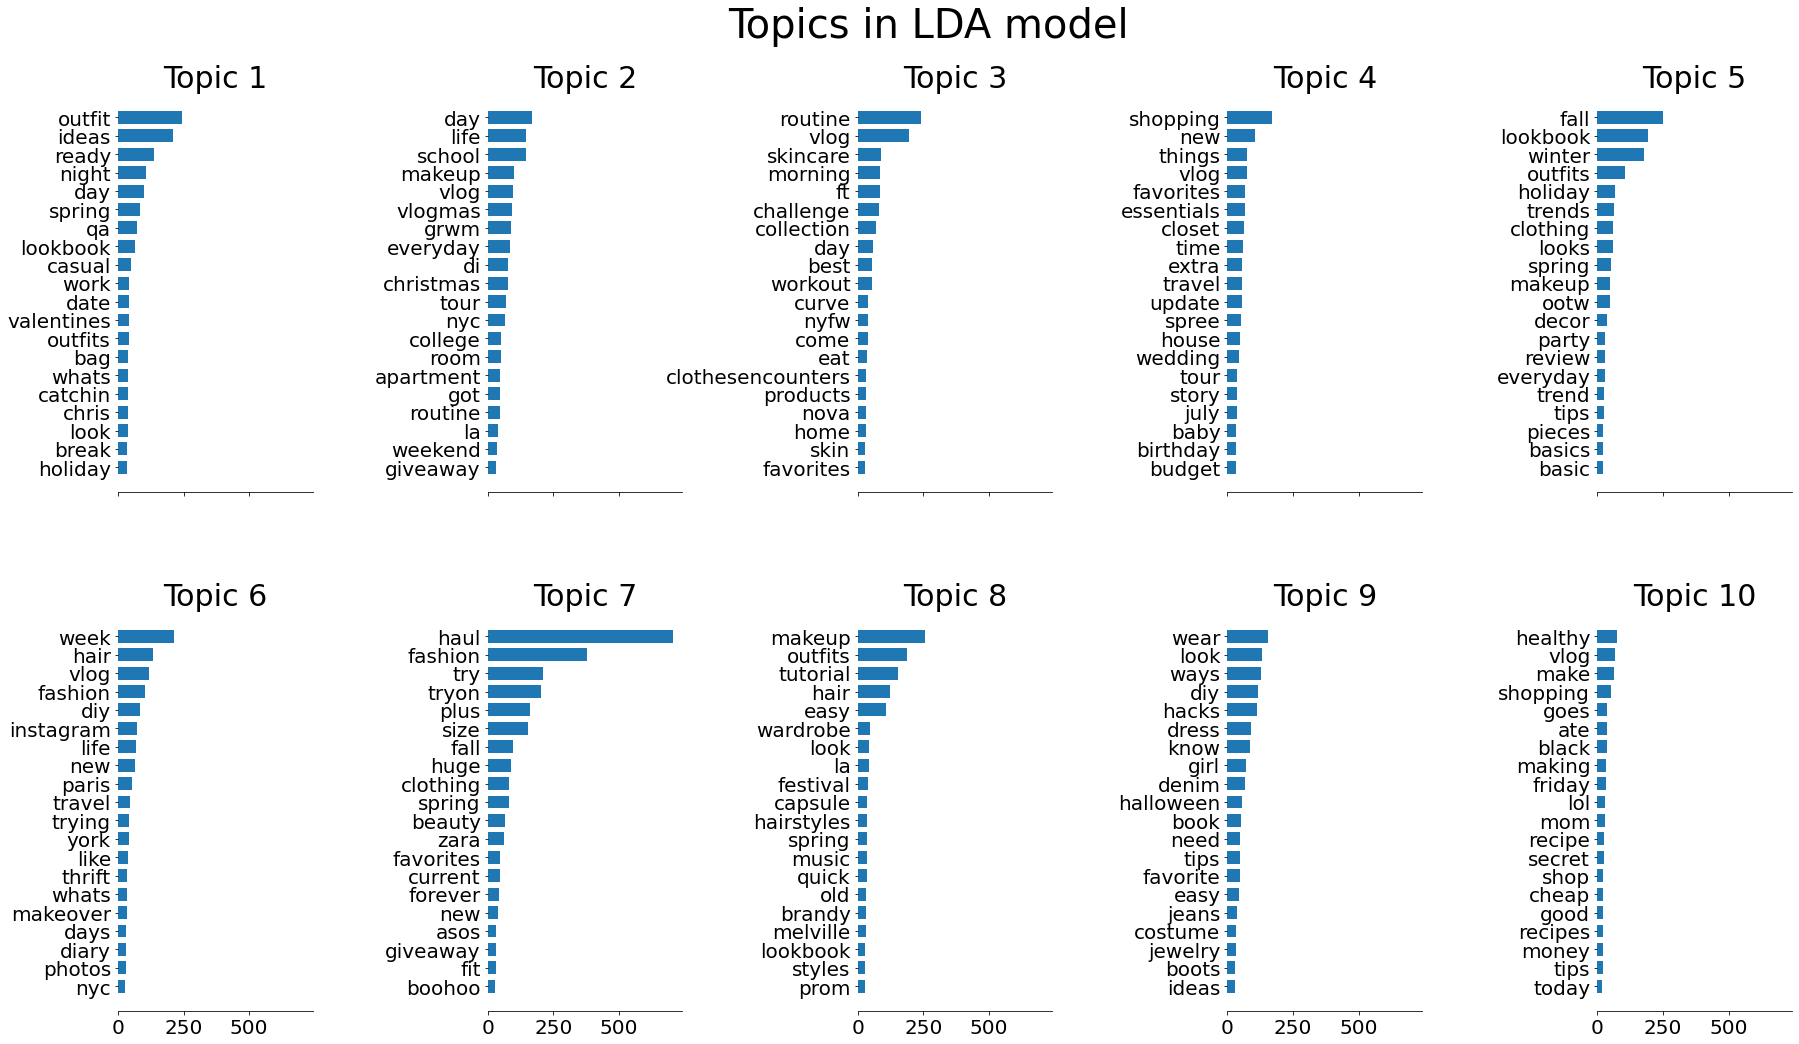

In [ ]:
import matplotlib.pyplot as plt
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

n_top_words = 20

tf_feature_names = tf_vectorizer.get_feature_names_out()
plot_top_words(lda, tf_feature_names, n_top_words, "Topics in LDA model")

In [ ]:
lda_arrary = lda.transform(tf[:])

df_lda = pd.DataFrame(lda_arrary)

df_lda_num = df_lda.apply(pd.to_numeric)

df_lda_num['Max'] = df_lda_num.idxmax(axis=1)

df_lda_cat = df_lda_num['Max']

# df_lda_cat

In [ ]:
df_join = df2.join(df_lda_cat, how='outer')
df_join

,labels,vid_length,passed_day,text,title_len,Uppercase,Uppercase_ratio,Max
0,1,10,926.0,Simple Things You Can Do To Look Better Enhanc...,11,11,1.000000,8
1,1,12,1201.0,How to Look Good Everyday Secrets to Live By,9,7,0.777778,8
2,1,6,1423.0,How To Look Stylish Everyday Steps to Getting ...,9,8,0.888889,3
3,1,9,1327.0,How To Build a Classic Wardrobe,6,5,0.833333,7
4,1,4,1446.0,Casual Date Night Outfits Lookbook What to Wea...,11,9,0.818182,0
...,...,...,...,...,...,...,...,...
6984,0,5,3864.0,Fall Scarf Collection Favorites,4,4,1.000000,4
6985,0,12,301.0,sq ft NYC Hotel Hours in New York City,9,8,0.888889,5
6986,0,8,29.0,Real Girl Talk health update anxiety and movin...,12,3,0.250000,3
6987,0,7,12.0,MY NIGHT ROUTINE cottagecore diys mochi donuts,7,14,2.000000,0


# Sentiment analysis/Intensity

In [ ]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()

blanks = []  # start with an empty list

df_simple = df_join[['text','labels']]

for i,lb,rv in df_simple.itertuples():  
    if type(rv)==str:            
        if rv.isspace():        
            blanks.append(i)     


df_join['scores'] = df_join['text'].apply(lambda title: sid.polarity_scores(title))


df_join['compound']  = df_join['scores'].apply(lambda score_dict: score_dict['compound'])

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [ ]:
df_final = df_join.drop(columns = ['Uppercase', 'scores'])
df_final.head()

,labels,vid_length,passed_day,text,title_len,Uppercase_ratio,Max,compound
0,1,10,926.0,Simple Things You Can Do To Look Better Enhanc...,11,1.000000,8,0.4404
1,1,12,1201.0,How to Look Good Everyday Secrets to Live By,9,0.777778,8,0.4404
2,1,6,1423.0,How To Look Stylish Everyday Steps to Getting ...,9,0.888889,3,0.0000
3,1,9,1327.0,How To Build a Classic Wardrobe,6,0.833333,7,0.0000
4,1,4,1446.0,Casual Date Night Outfits Lookbook What to Wea...,11,0.818182,0,0.2023


We see that the data contains both text in the `Review Text` and `Title` column as well as tabular features in the `Division Name`, `Department Name`, and `Class Name` columns. 

In [ ]:
df_final.describe(include=np.object)

,text
count,6989
unique,6808
top,April Favorites
freq,8


In [ ]:
df_final.describe()

,vid_length,passed_day,title_len,Uppercase_ratio,Max,compound
count,6989.000000,6989.000000,6989.000000,6989.000000,6989.000000,6989.000000
mean,10.313206,1329.096151,6.437115,2.074956,4.293747,0.107427
std,6.715510,822.655465,2.627504,1.778889,2.844922,0.265145
min,1.000000,-236.000000,1.000000,0.000000,0.000000,-0.824000
25%,6.000000,725.000000,5.000000,1.000000,2.000000,0.000000
50%,9.000000,1232.000000,6.000000,1.000000,4.000000,0.000000
75%,13.000000,1796.000000,8.000000,3.000000,7.000000,0.273200
max,59.000000,4160.000000,19.000000,13.000000,9.000000,0.944200


In this demonstration, we split our data into 8:1:1 training splits. We also save our splits to `train.csv`, `val.csv`, and `test.csv` as this is the format our dataloader requires.


In [ ]:
df_final.to_csv( "/content/gdrive/My Drive/MAS-thesis/final_full_youtube_data_2.csv", index=False, encoding='utf-8-sig')